In [70]:
import pandas as pd
import datetime
import os
import csv
import numpy as np

# Constants

In [71]:
DATASET_PATH = '../data/2019-02-01-2019-03-28-India.csv'
SRC_DIR_NEWS_TEXT_ONLY = './data/news_text_only/'
NEWS_START_DATE = datetime.datetime.strptime("2019-02-24", "%Y-%m-%d").date()
NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_PKL = './data/news_signal_for_violence.pkl'
NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_CSV = './data/news_signal_for_violence.csv'

In [72]:
# builds a set which stores <date__location> of violence
violence_log = set()
LAST_VIOLENCE_DATE = None

# Data

## ACLED

In [73]:
# Read ACLED data
data = pd.read_csv(DATASET_PATH)

In [74]:
def build_violence_log_key(log_date, log_location):
    return "{}__{}".format(log_date, log_location)

## Populate the violence_log set

In [75]:
# populates violence_log
for index, row in data.iterrows():
    if index == 0:
        pass
    else:
        d = datetime.datetime.strptime(row['event_date'], "%d %B %Y")
        event_date = d.strftime('%Y-%m-%d')
        violence_log.add(build_violence_log_key(event_date, row['location']))
        if LAST_VIOLENCE_DATE is None:
            # we just need the first event date as dataset has events ordered latest first
            LAST_VIOLENCE_DATE = d.date()

print("Last Violence Date: {}".format(LAST_VIOLENCE_DATE))
            

Last Violence Date: 2019-03-23


## Get 15 most active cities

In [76]:
# Get most active cities
locations = []

# read relevant locations
with open("./data/top-15-india-locations.csv", 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file, fieldnames=['name', 'lat', 'long', 'freq'])

    # each row is an ordered dict
    for row in csv_reader:
        locations.append(row)

## Helper method to get News data for a particular date

In [77]:
def read_news_text_only(date, location):
    filepath = "{}{}__{}.txt".format(SRC_DIR_NEWS_TEXT_ONLY, date, location)
    if os.path.isfile(filepath):
        with open(filepath, 'r') as text_file:
            return text_file.read()
    else:
        return None

## Helper method to create Final Dataset

In [78]:
# method for creating dataset for scikit learn methods
def create_dataset(start_date, days, dataset_label):
    
    news_col = []
    labels_col = []
    src = []

    for curr_date in (start_date + datetime.timedelta(days=i) for i in range(days)):
        
        violence_date = curr_date + datetime.timedelta(days=2)
        print("Included news broadcasted on {} for violence on {}".format(curr_date, violence_date))        
        
        for location in locations:
            
            # check if violence occurred
            if build_violence_log_key(violence_date, location['name']) in violence_log:
                label = 'VIOLENCE'
            else:
                label = 'NO_VIOLENCE'
            news = read_news_text_only(curr_date, location['name'])
            if news is not None:
                news_col.append(news)
                labels_col.append(label)
                src.append(build_violence_log_key(violence_date, location['name']))
        
    return {'news': news_col, 'labels': labels_col, 'src': src}
        

## Create Final dataset

In [79]:
# count_of_news_days is the number of days we will process for
delta = LAST_VIOLENCE_DATE - NEWS_START_DATE
count_of_news_days = delta.days - 1

processed_data = create_dataset(NEWS_START_DATE, count_of_news_days, "DS")

news_signal_for_violence_ds = pd.DataFrame(processed_data, columns= ['news', 'labels', 'src'])


Included news broadcasted on 2019-02-24 for violence on 2019-02-26
Included news broadcasted on 2019-02-25 for violence on 2019-02-27
Included news broadcasted on 2019-02-26 for violence on 2019-02-28
Included news broadcasted on 2019-02-27 for violence on 2019-03-01
Included news broadcasted on 2019-02-28 for violence on 2019-03-02
Included news broadcasted on 2019-03-01 for violence on 2019-03-03
Included news broadcasted on 2019-03-02 for violence on 2019-03-04
Included news broadcasted on 2019-03-03 for violence on 2019-03-05
Included news broadcasted on 2019-03-04 for violence on 2019-03-06
Included news broadcasted on 2019-03-05 for violence on 2019-03-07
Included news broadcasted on 2019-03-06 for violence on 2019-03-08
Included news broadcasted on 2019-03-07 for violence on 2019-03-09
Included news broadcasted on 2019-03-08 for violence on 2019-03-10
Included news broadcasted on 2019-03-09 for violence on 2019-03-11
Included news broadcasted on 2019-03-10 for violence on 2019-0

## Persist dataset to disk 

In [80]:
# persists final dataset as Pickle file
news_signal_for_violence_ds.to_pickle(NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_PKL)

# persists final dataset as CSV
news_signal_for_violence_ds.to_csv(NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_CSV, sep=',', encoding='utf-8')


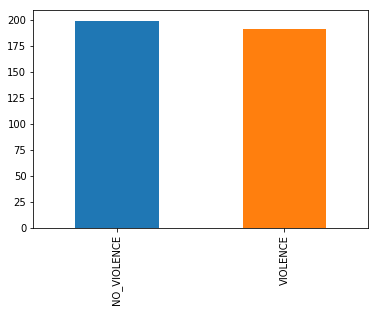

In [81]:
# Check label frequency in final dataset
news_signal_for_violence_ds.labels.value_counts().plot(kind='bar');

## Read final dataset from disk

In [82]:
news_signal_for_violence_ds = pd.read_pickle(NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_PKL)
news_signal_for_violence_ds

,news,labels,src
0,deputy sp killed in encounter in jammu and ka...,VIOLENCE,2019-02-26__Jammu
1,"senior police officer , indian army jawan ki...",NO_VIOLENCE,2019-02-26__Srinagar
2,toxic moonshine kills 133 people and leaves h...,VIOLENCE,2019-02-26__Delhi-New Delhi
3,ludhiana land scam: ask minister ashu to resi...,VIOLENCE,2019-02-26__Ludhiana
4,"raja-maharaja government in punjab , #39;mah...",NO_VIOLENCE,2019-02-26__Bathinda
5,assam hooch tragedy toll rises to 124 at leas...,VIOLENCE,2019-02-26__Guwahati
6,,VIOLENCE,2019-02-26__Imphal
7,ysrcp chief jagan in london to bring hawala m...,VIOLENCE,2019-02-26__Hyderabad
8,"cheque bounce cases: five days later , farme...",NO_VIOLENCE,2019-02-26__Patiala
9,india vs pakistan: sourav ganguly clarifies s...,NO_VIOLENCE,2019-02-26__Kolkata


## Cleaning the final dataset

In [83]:
news_signal_for_violence_ds.describe()

,news,labels,src
count,390,390,390
unique,377,2,390
top,,NO_VIOLENCE,2019-03-07__Guwahati
freq,14,199,1


In [84]:
# Removing null or empty values
news_signal_for_violence_ds.drop(['src'], inplace=True, axis=1)
news_signal_for_violence_ds.dropna(axis = 0, how ='any') 
news_signal_for_violence_ds = news_signal_for_violence_ds.sample(frac=1).reset_index(drop=True)
news_signal_for_violence_ds['news'].replace('', np.nan, inplace=True)
news_signal_for_violence_ds.dropna(axis=0, how='any', inplace=True)

In [85]:
# Renaming 'label' attrivute to 'violence_label'
news_signal_for_violence_ds = news_signal_for_violence_ds.rename(columns = {'labels': 'violence_label'})

## Splitting data into Training and Test set

In [86]:
# y are the labels
y = news_signal_for_violence_ds.violence_label

# dropping the 'src' attribute as it is not required
news_signal_for_violence_ds.drop(['violence_label'], axis=1, inplace=True)

# X is the news data
X = news_signal_for_violence_ds.news

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Helper methods to create dataset for FastTest


In [87]:

# method for creating fasttext sets
def create_fasttext_set(records, labels, set_tag):

    OUTPUT_DIR = "./fasttext/"
    out_file_path = "{}{}.txt".format(OUTPUT_DIR, set_tag)
    
    records = records.tolist()
    labels = labels.tolist()
    
    no_of_records = len(records)
    
    combined = ""
    for i in range(no_of_records):
        record_data = records[i]
        record_label = 0 if labels[i] == "NO_VIOLENCE" else 1
        combined += "__label__{} {}{}".format(record_label, record_data, os.linesep)
        
    with open(out_file_path, 'w') as out_file:
        out_file.write(combined)
    

def create_fasttext_train_and_test_sets(X_train, X_test, y_train, y_test):
    
    create_fasttext_set(X_train, y_train, "train_set")
    create_fasttext_set(X_test, y_test, "test_set")


In [88]:
# Writes generated datasets to disk
create_fasttext_train_and_test_sets(X_train, X_test, y_train, y_test)

# Building the Model

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Multinomial Naive Bayes

In [90]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print("Multinomial Naive Bayes")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Multinomial Naive Bayes
accuracy 0.6578947368421053
              precision    recall  f1-score   support

 NO_VIOLENCE       0.60      0.81      0.69        36
    VIOLENCE       0.75      0.53      0.62        40

   micro avg       0.66      0.66      0.66        76
   macro avg       0.68      0.67      0.65        76
weighted avg       0.68      0.66      0.65        76



## SGD Classfier

In [91]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print("SGD Classifier")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

SGD Classifier
accuracy 0.5921052631578947
              precision    recall  f1-score   support

 NO_VIOLENCE       0.55      0.81      0.65        36
    VIOLENCE       0.70      0.40      0.51        40

   micro avg       0.59      0.59      0.59        76
   macro avg       0.62      0.60      0.58        76
weighted avg       0.63      0.59      0.58        76



## Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print("Logistic Regression")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Logistic Regression
accuracy 0.5921052631578947
              precision    recall  f1-score   support

 NO_VIOLENCE       0.55      0.72      0.63        36
    VIOLENCE       0.66      0.47      0.55        40

   micro avg       0.59      0.59      0.59        76
   macro avg       0.60      0.60      0.59        76
weighted avg       0.61      0.59      0.59        76

